# LGBM을 활용한 베이스라인

In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split

import lightgbm as lgb
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## 1. 데이터 로딩

In [184]:
main_df = pd.read_csv("/opt/ml/input/data/train/train_ratings.csv")

## 2. 데이터셋 만들기

In [ ]:
# set(list(main_df.groupby('user')['item'])[0][1]) #11번 유저가 본 아이템들

In [43]:
main_df['rating'] = 1
main_df = main_df.drop(columns='time', axis=1)

In [45]:
main_df.head(3)

,user,item,rating
0,11,4643,1
1,11,170,1
2,11,531,1


In [46]:
# 3. Negative instance 생성 : 각 유저별 true:false = 5:5, 20분정도 소요
print("Create Nagetive instances")
# num_negative = 50
user_group_dfs = list(main_df.groupby('user')['item'])

first_row = True
items = set(main_df.loc[:, 'item'])

for u, u_items in tqdm(user_group_dfs):
    u_items = set(u_items)                 #해당 유저가 본 아이템
    i_user_neg_item = np.random.choice(list(items - u_items), len(u_items), replace=False)
    
    i_user_neg_df = pd.DataFrame({'user': [u]*len(u_items), 'item': i_user_neg_item, 'rating': [0]*len(u_items)})
    if first_row == True:
        user_neg_dfs = i_user_neg_df
        first_row = False
    else:
        user_neg_dfs = pd.concat([user_neg_dfs, i_user_neg_df], axis = 0, sort=False)

result = pd.concat([main_df, user_neg_dfs], axis = 0, sort=False)
result.to_csv("user_direct_neg_sampling.csv", index=False)
result.isna().sum()

Create Nagetive instances


100%|██████████| 31360/31360 [20:40<00:00, 25.27it/s]


user      0
item      0
rating    0
dtype: int64

In [47]:
result.to_csv("user_item_rating_neg_sampling.csv", index=False)

In [56]:
neg_train_result = result

In [57]:
neg_train_result.shape

(10308942, 3)

In [52]:
ease_result = pd.read_csv('/opt/ml/input/fighting/Recbole/EASE_best.csv')

In [54]:
ease_result.shape

(9408000, 2)

In [58]:
# 차집합 구하기
lgbm_train_df = pd.concat([neg_train_result, ease_result, ease_result]).drop_duplicates(subset=['user', 'item'], keep=False)


In [64]:
lgbm_train_df.shape

(10070694, 3)

In [62]:
lgbm_train_df.to_csv("lgbm_train_df.csv", index=False)

In [60]:
# 10308942 - 10070694 = 약 23만 8천

In [63]:
lgbm_inference_df = ease_result

## 3. Feature Engineering
모듈화 한 피처들을 merge하면 된다.

In [40]:
# lgbm_train_df = pd.read_csv("/opt/ml/input/fighting/model/lgbm_train_df.csv")
# lgbm_inference_df = pd.read_csv("/opt/ml/input/fighting/Recbole/EASE_best.csv")

In [44]:
year_df = pd.read_csv("/opt/ml/input/fighting/FE/year/year_missingno.csv")
genre_df = pd.read_csv("/opt/ml/input/fighting/FE/genre/genre_bert_fe.csv")
director_inter_cnt = pd.read_csv("/opt/ml/input/fighting/FE/director/director_inter_cnt.csv")
writer_inter_cnt = pd.read_csv("/opt/ml/input/fighting/FE/writer/writer_inter_cnt.csv")
item_interaction = pd.read_csv("/opt/ml/input/fighting/FE/item/item_interaction_cnt.csv")
item_popular_dir_max_sum_cnt = pd.read_csv("/opt/ml/input/fighting/FE/director/item_popular_dir_max_sum_cnt.csv")
item_popular_wri_max_sum_cnt = pd.read_csv("/opt/ml/input/fighting/FE/writer/item_popular_wri_max_sum_cnt.csv")
user_seen_item_statistic = pd.read_csv("/opt/ml/input/fighting/FE/user/user_seen_item_statistic.csv")

In [46]:
train_df = lgbm_train_df.merge(year_df, how='left', on='item')
train_df = train_df.merge(genre_df, how='left', on='item')
train_df = train_df.merge(director_inter_cnt, how='left', on='item')
train_df = train_df.merge(writer_inter_cnt, how='left', on='item')
train_df = train_df.merge(item_interaction, how='left', on='item')
train_df = train_df.merge(item_popular_dir_max_sum_cnt, how='left', on='item')
train_df = train_df.merge(item_popular_wri_max_sum_cnt, how='left', on='item')
train_df = train_df.merge(user_seen_item_statistic, how='left', on='user')

In [47]:
train_df.shape

(10070694, 14)

In [48]:
train_df.head(3)

,user,item,rating,year,genre_embedding,director_info,writer_info,item_cnt,dir_max_cnt,dir_sum_cnt,wri_max_cnt,wri_sum_cnt,seen_item_inter_mean,seen_item_inter_std
0,11,4643,1.0,2001.0,-0.010404,2859.444444,4146.333333,1122,7743,51470,8936,21339,3719.351064,4316.497874
1,11,170,1.0,1995.0,-0.010290,583.714286,269.562069,1107,2092,4086,1107,1107,3719.351064,4316.497874
2,11,531,1.0,1993.0,-0.010649,430.333333,5684.000000,966,966,1291,7743,19336,3719.351064,4316.497874


In [77]:
inference_df = lgbm_inference_df.merge(year_df, how='left', on='item')
inference_df = inference_df.merge(genre_df, how='left', on='item')

In [49]:
inference_df = lgbm_inference_df.merge(year_df, how='left', on='item')
inference_df = inference_df.merge(genre_df, how='left', on='item')
inference_df = inference_df.merge(director_inter_cnt, how='left', on='item')
inference_df = inference_df.merge(writer_inter_cnt, how='left', on='item')
inference_df = inference_df.merge(item_interaction, how='left', on='item')
inference_df = inference_df.merge(item_popular_dir_max_sum_cnt, how='left', on='item')
inference_df = inference_df.merge(item_popular_wri_max_sum_cnt, how='left', on='item')
inference_df = inference_df.merge(user_seen_item_statistic, how='left', on='user')

In [50]:
inference_df.shape

(9408000, 13)

In [51]:
inference_df.head(3)

,user,item,year,genre_embedding,director_info,writer_info,item_cnt,dir_max_cnt,dir_sum_cnt,wri_max_cnt,wri_sum_cnt,seen_item_inter_mean,seen_item_inter_std
0,11,4370,2001.0,-0.010420,4369.500000,5626.166667,3173,14224,130434,3734,11878,3719.351064,4316.497874
1,11,4886,2001.0,-0.010383,16267.000000,33020.428571,10826,12105,33840,12217,60006,3719.351064,4316.497874
2,11,47,1995.0,-0.010262,4853.181818,4527.200000,13857,18437,53385,13857,18569,3719.351064,4316.497874


## 4. LGBM Train/Test 데이터 셋

In [108]:
# user별 interaction을 8:2로 split code
# 하루종일 걸릴 것 같다.. (예상시간 12시간 넘었음)

# import random

# def custom_train_test_split(df, ratio=0.8):
#     # user별 interaction을 8:2로 split
#     user_group_dfs = list(df.groupby('user')['item'])

#     first_row = True
#     items = set(df.loc[:, 'item']) #아이템 개수 6807

#     for u, u_items in tqdm(user_group_dfs):
        
#         random.shuffle(list(u_items))
#         u_items = list(u_items)

#         train_size = int(ratio * len(u_items))
#         train_set_item = u_items[:train_size]
#         test_set_item = u_items[train_size:]

#         train_mask = df['item'].isin(train_set_item)
#         test_mask = df['item'].isin(test_set_item)

#         # Use the boolean masks to create the training and test sets
#         train_set = df[train_mask]
#         test_set = df[test_mask]

#         if first_row == True:
#             train = train_set
#             test = test_set
#             first_row = False
#         else:
#             train = pd.concat([train, train_set], axis=0, sort=False)
#             test = pd.concat([test, test_set], axis=0, sort=False)
#     return train, test

# train_set, test_set = custom_train_test_split(train_df)

In [52]:
train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

In [53]:
train_set.columns

Index(['user', 'item', 'rating', 'year', 'genre_embedding', 'director_info',
       'writer_info', 'item_cnt', 'dir_max_cnt', 'dir_sum_cnt', 'wri_max_cnt',
       'wri_sum_cnt', 'seen_item_inter_mean', 'seen_item_inter_std'],
      dtype='object')

In [104]:
# X, y 값 분리
FEATS = ['user', 'item', 'year', 'genre_embedding', 'item_cnt', 'seen_item_inter_mean', 'seen_item_inter_std', 'dir_max_cnt', 'dir_sum_cnt', 'wri_max_cnt',
       'wri_sum_cnt', 'director_info', 'writer_info']

y_train = train_set['rating']
train = train_set.drop(['rating'], axis=1)

y_test = test_set['rating']
test = test_set.drop(['rating'], axis=1)

In [105]:
train.shape, test.shape

((8056555, 13), (2014139, 13))

In [106]:
# !python -m pip install lightgbm

In [107]:
categorical_features = ['user','item','year']

In [108]:
lgb_train = lgb.Dataset(train[FEATS], y_train, categorical_feature=categorical_features)
lgb_test = lgb.Dataset(test[FEATS], y_test, categorical_feature=categorical_features)

## 5. 훈련 및 검증

In [109]:
model = lgb.train(
    {'objective': 'binary',
     'category_feat':categorical_features}, 
    lgb_train,
    valid_sets=[lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100,
)

preds = model.predict(test[FEATS])
rmse = mean_squared_error(y_test, preds)

print(f'RMSE : {rmse:.5f}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: category_feat
[LightGBM] [Warning] Unknown parameter: category_feat
[LightGBM] [Info] Number of positive: 4123632, number of negative: 3932923
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32618
[LightGBM] [Info] Number of data points in the train set: 8056555, number of used features: 13


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: category_feat
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511836 -> initscore=0.047351
[LightGBM] [Info] Start training from score 0.047351
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.383564
[200]	valid_0's binary_logloss: 0.380419
[300]	valid_0's binary_logloss: 0.377739
[400]	valid_0's binary_logloss: 0.376208
[500]	valid_0's binary_logloss: 0.375157
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.375157
RMSE : 0.11955



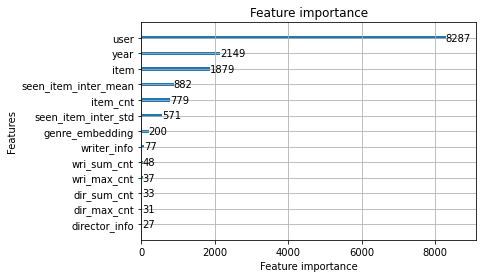

In [110]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 6. Inference

In [61]:
tmp = pd.read_csv('/opt/ml/input/data/eval/sample_submission.csv')
lst = list(tmp['user'].values)
user_list = list(set(tmp['user'].values))
user_list = sorted(user_list)

In [63]:
# user_list

In [111]:
# Top 300개를 뽑았을 때 약 13분정도 소요
first_row = True

for user in tqdm(user_list):
    user_df = inference_df[inference_df['user']==user][FEATS]
    
    y = model.predict(user_df)
    y = torch.from_numpy(y)
    _, indices = torch.topk(y, 10)
    
    user_rec = user_df.iloc[indices,:]
    
    if first_row == True:
        result = user_rec
        first_row = False
    else:
        result = pd.concat([result, user_rec], axis=0, sort=False)

print("dataframe으로 만드는 중")
sub = pd.DataFrame(result, columns=["user","item"])
print("csv 파일로 내보내는 중")
sub.to_csv(f"EASE_LGBM_{rmse:.5f}_{FEATS}.csv", index=False)
print("csv 파일로 내보내기 완료!")

100%|██████████| 31360/31360 [12:25<00:00, 42.07it/s]


dataframe으로 만드는 중
csv 파일로 내보내는 중
csv 파일로 내보내기 완료!


In [112]:
print(f"EASE 결과 item 중 item번호가 10000 미만 item 개수: {len(inference_df.loc[(inference_df['item'] < 10000)])}\n")
print(f"EASE 결과 item 중 item번호가 10000 이상 item 개수: {len(inference_df.loc[(inference_df['item'] >= 10000)])}\n")
print(f"LGBM 결과 item 중 item번호가 10000 미만 item 개수: {len(sub.loc[(sub['item'] < 10000)])}\n")
print(f"LGBM 결과 item 중 item번호가 10000 이상 item 개수: {len(sub.loc[(sub['item'] >= 10000)])}\n")
print("비율이 좀 이상한 것 같다..")

EASE 결과 item 중 item번호가 10000 미만 item 개수: 7038430

EASE 결과 item 중 item번호가 10000 이상 item 개수: 2369570

LGBM 결과 item 중 item번호가 10000 미만 item 개수: 282194

LGBM 결과 item 중 item번호가 10000 이상 item 개수: 31406

비율이 좀 이상한 것 같다..


In [230]:
# 대신 예측한 아이템 300개 내에선 10개 추출은 잘 되는 것 같다.
inf_res = set(inference_df.loc[(inference_df['user'] == 11)]['item'].values)

In [231]:
sub_res = set(sub.loc[(sub['user'] == 11)]['item'].values)

In [232]:
sub_res - inf_res

set()

In [ ]:
# year 